In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_auc_score
from scipy.sparse import vstack, hstack
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
# from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import ClassifierChain
import lightgbm
from sklearn.manifold import TSNE
# from sklearn.multiclass import OneVsRestClassifier
# from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
_ = """
Dataset decription: https://scikit-learn.org/0.17/datasets/rcv1.html
"""

In [3]:
from sklearn.datasets import fetch_rcv1
rcv1_train = fetch_rcv1(subset='train')
rcv1_test = fetch_rcv1(subset='test')

# About data

In [4]:
print("Train Data shape:", rcv1_train.data.shape)
print("Train Target shape:", rcv1_train.target.shape)
print("Test Data shape:", rcv1_test.data.shape)
print("Test Target shape:", rcv1_test.target.shape)

Train Data shape: (23149, 47236)
Train Target shape: (23149, 103)
Test Data shape: (781265, 47236)
Test Target shape: (781265, 103)


In [5]:
trainX = rcv1_train.data
trainY = rcv1_train.target
testX = rcv1_test.data
testY = rcv1_test.target

# Training data explore

In [6]:
def count_nnz(data):
    nnz = []
    for row in data:
        nnz.append(row.nnz)
    return nnz

nnzX = count_nnz(trainX)
nnzY = count_nnz(trainY)

In [7]:
print("Minimum numbers of catigories for one documnet: ", min(nnzY))
print("Maximum numbers of catigories for one documnet: ", max(nnzY))
print("Minimum numbers of words for one documnet: ", min(nnzX))
print("Maximum numbers of words for one documnet: ", max(nnzX))

Minimum numbers of catigories for one documnet:  1
Maximum numbers of catigories for one documnet:  14
Minimum numbers of words for one documnet:  6
Maximum numbers of words for one documnet:  980


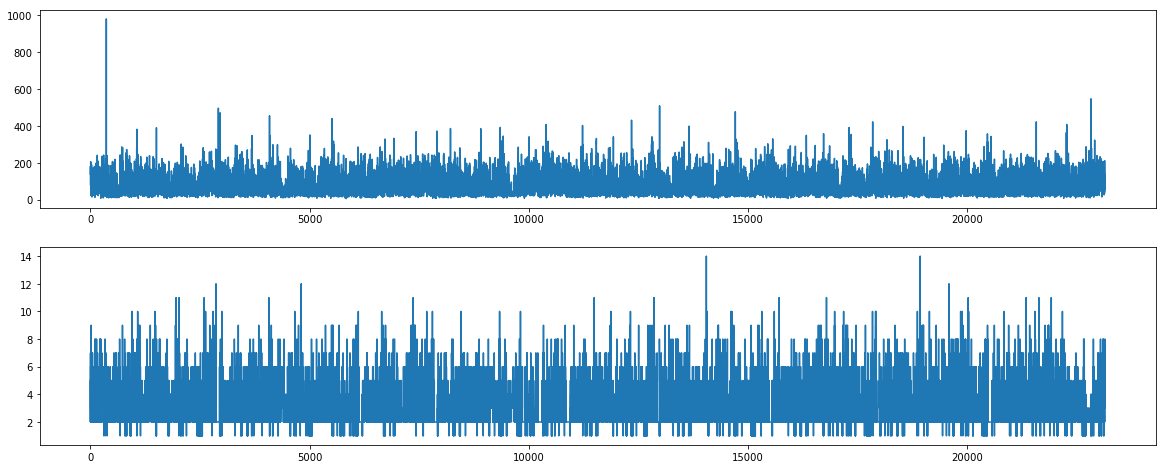

In [8]:
plt.figure(figsize=(20, 8))
plt.subplot(211)
plt.plot(nnzX)
plt.subplot(212)
plt.plot(nnzY)
plt.show()

(-0.02222813608030608, 0.0007190760163549163)


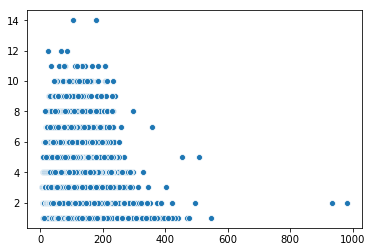

In [9]:
print(pearsonr(nnzX, nnzY))
sns.scatterplot(nnzX, nnzY)
plt.show()

In [14]:
def distribution(data_sparce, top_n=50, ticks=True, name=""):
    print(name)
    plt.figure(figsize=(20, 6))
    data = data_sparce.toarray()
    data = np.transpose(data)
    data = np.apply_along_axis(lambda x: np.where(x == 0, 0, 1), 1, data)
    data = np.sum(data, axis=1)
    print("Number of zero values:", np.sum(data==0))
    idx = np.argsort(data)[::-1]
    if ticks:
        print("Most popular label: %s (%d)" %(rcv1_train.target_names[idx[0]], idx[0]))
        print("Most rare label: %s (%d)" %(rcv1_train.target_names[idx[-1]], idx[-1]))
    if top_n > data.shape[0]:
        top_n = data.shape[0]
    x = range(top_n)
    plt.bar(x, np.take(data, idx)[:top_n])
    if ticks:
        plt.xticks(x, np.take(rcv1_train.target_names, idx)[:top_n], rotation='vertical')
    plt.show()

The most common categories
Number of zero values: 2
Most popular label: CCAT (33)
Most rare label: E312 (49)


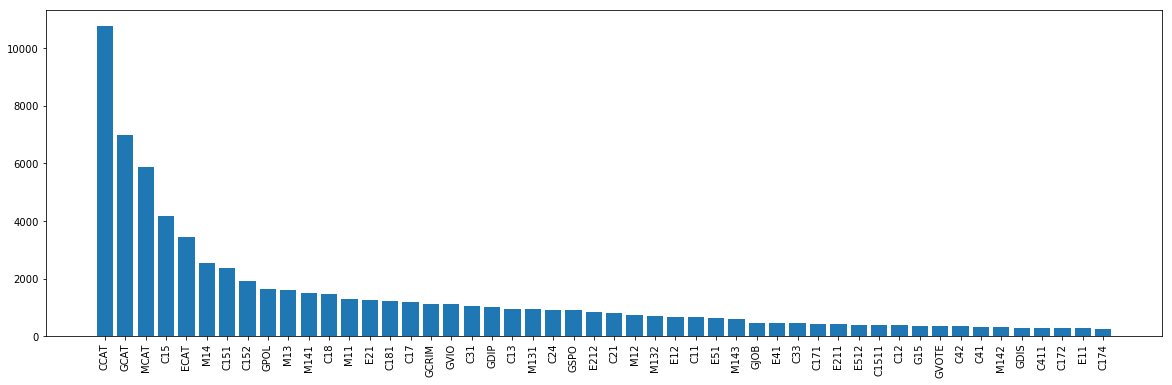

The most common words
Number of zero values: 84


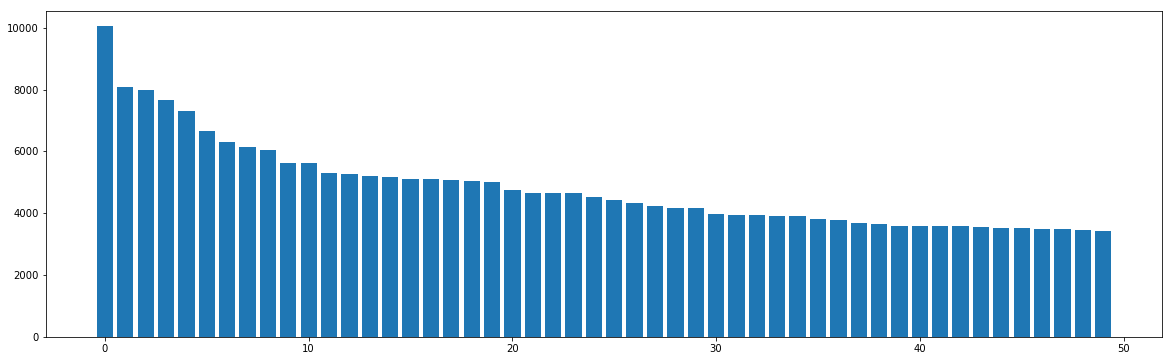

In [15]:
distribution(trainY, name="The most common categories")
distribution(trainX, ticks=False, name="The most common words")

The most common categories in test set
Number of zero values: 0
Most popular label: CCAT (33)
Most rare label: GMIL (80)


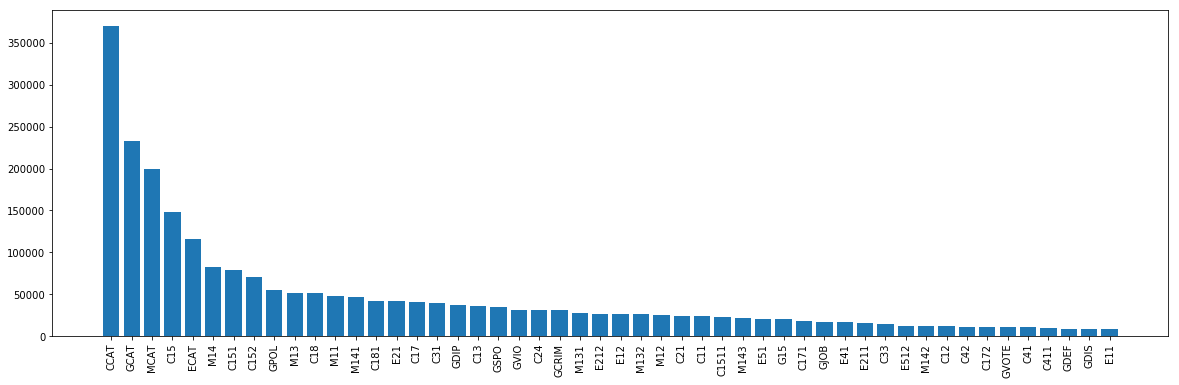

In [16]:
distribution(testY, name="The most common categories in test set")

# Multilabel classification

In [14]:
_ = """
Function for one vs rest conception.
As we can see earlier in test set two of the categories are not presented
if such situation happens - then sample some stratified data from test set
"""

def oneVSrest(x_train, y_train, x_test, y_test, model):
    accuracies = []
    predictions = []
    predictions_labels = []
    for category in tqdm(range(y_train.shape[1])):
        try:
            model.fit(x_train, y_train.toarray()[:, category])
            try:
                prediction = model.predict_proba(x_test)
                predictions.append(prediction)
            except:
                pass
            pred_labels = model.predict(x_test)
            predictions_labels.append(pred_labels)
            accuracies.append(accuracy_score(y_test.toarray()[:, category], pred_labels))
        except ValueError as e:
            if not "This solver needs samples of at least 2 classes" in str(e):
                raise
            # resample training data from test to if no class present in train set
            x_train_str, _, y_train_str, _ = train_test_split(x_test, y_test, test_size=0.8,
                                                              random_state=42)
            y_str = vstack([y_train, y_train_str]).toarray()
            model.fit(vstack([x_train, x_train_str]), y_str[:, category])
            try:
                prediction = model.predict_proba(x_test)
                predictions.append(prediction)
            except:
                pass
            pred_labels = model.predict(x_test)
            predictions_labels.append(pred_labels)
            accuracies.append(accuracy_score(y_test.toarray()[:, category], pred_labels))
    return accuracies, predictions, predictions_labels

In [6]:
def plot_roc_curve(testY, predictions):
    common_index = 33
    fpr_c, tpr_c, thresholds_c = roc_curve(testY.toarray()[:, common_index], predictions[:, common_index])
    auc_value_c = auc(fpr_c, tpr_c)

    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(fpr_c, tpr_c, label='ROC curve (auc = %.2f)' %auc_value_c)
    plt.legend()
    plt.title('ROC curve for most common label (%s) in test set' %(rcv1_train.target_names[common_index]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

    rare_index = 80
    fpr_r, tpr_r, thresholds_r = roc_curve(testY.toarray()[:, rare_index], predictions[:, rare_index])
    auc_value_r = auc(fpr_r, tpr_r)
    plt.subplot(122)
    plt.plot(fpr_r, tpr_r, label='ROC curve (auc = %.2f)' %auc_value_r)
    plt.legend()
    plt.title('ROC curve for most rare label (%s) in test set' %(rcv1_train.target_names[rare_index]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

## Train One VS Rest & Logistic Regression

In [10]:
log_reg = LogisticRegression(C=0.1, solver='sag', penalty='l2')
lr_accuracies, lr_predictions, lr_predictions_labels = oneVSrest(trainX, trainY, testX, testY, log_reg)

HBox(children=(IntProgress(value=0, max=103), HTML(value='')))

In [13]:
lr_predictions_ = [p[:, 1] for p in lr_predictions]
lr_predictions_ = np.stack(lr_predictions_, axis=1)
lr_predictions_labels_ = np.stack(lr_predictions_labels, axis=1)

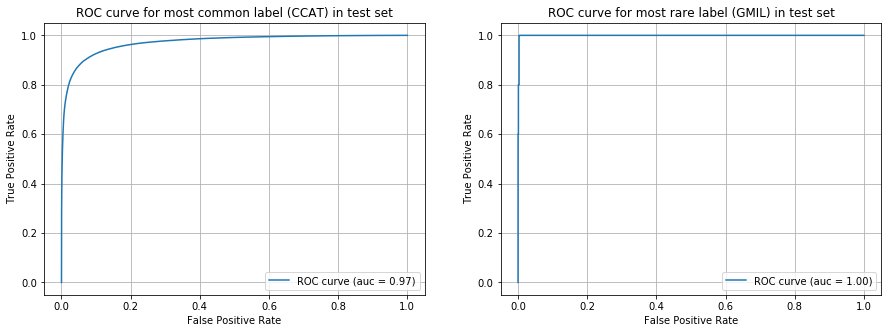

In [14]:
plot_roc_curve(testY, lr_predictions_)

## Train One VS Rest & LinearSVC

In [15]:
svc = LinearSVC()
svc_accuracies, svc_predictions, svc_predictions_labels = oneVSrest(trainX, trainY, testX, testY, svc)

HBox(children=(IntProgress(value=0, max=103), HTML(value='')))

In [16]:
svc_predictions_labels_ = np.stack(svc_predictions_labels, axis=1)

## Train One VS Rest & Naive Bayes

In [27]:
nb = MultinomialNB()
nb_accuracies, nb_predictions, nb_predictions_labels = oneVSrest(trainX, trainY, testX, testY, nb)

HBox(children=(IntProgress(value=0, max=103), HTML(value='')))

In [32]:
nb_predictions_ = [p[:, 1] for p in nb_predictions]
nb_predictions_ = np.stack(nb_predictions_, axis=1)
nb_predictions_labels_ = np.stack(nb_predictions_labels, axis=1)

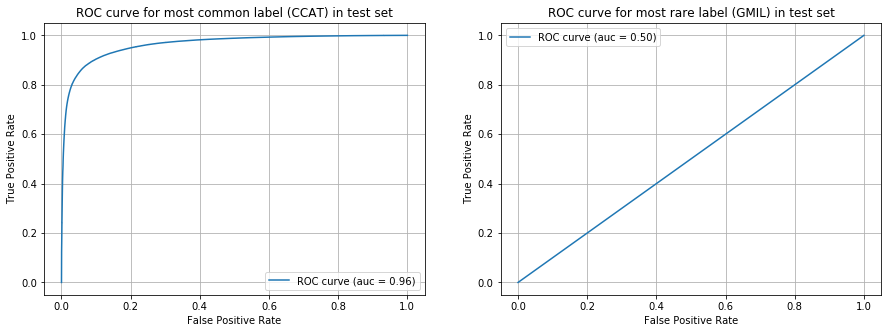

In [34]:
plot_roc_curve(testY, nb_predictions_)

## Train One VS Rest & Gradient Boosted Trees (lightgbm)

In [36]:
lgbm = lightgbm.LGBMClassifier(objective='binary', learning_rate=0.05, n_estimators=50)
lgbm_accuracies, lgbm_predictions, lgbm_predictions_labels = oneVSrest(trainX, trainY, testX, testY, lgbm)

HBox(children=(IntProgress(value=0, max=103), HTML(value='')))

In [38]:
lgbm_predictions_ = [p[:, 1] for p in lgbm_predictions]
lgbm_predictions_ = np.stack(lgbm_predictions_, axis=1)
lgbm_predictions_labels_ = np.stack(lgbm_predictions_labels, axis=1)

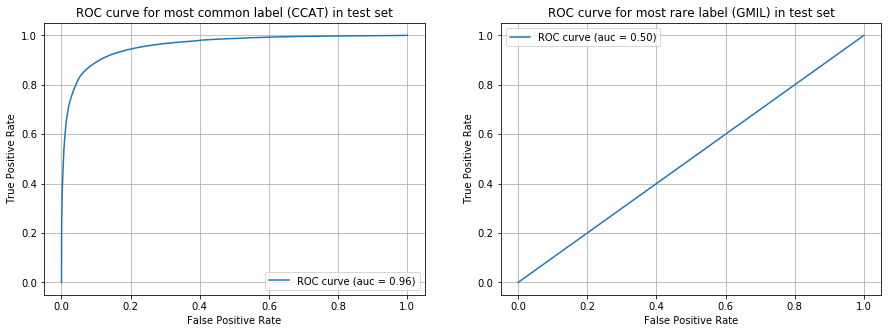

In [66]:
plot_roc_curve(testY, lgbm_predictions_)

## NBLR (Naive Bayes - Logistic Regression)

In [61]:
def nblr(x_train, y_train, x_test, y_test):
    predictions = []
    predictions_labels = []
    def pr(y_i, y, x_train):
        p = x_train[y==y_i].sum(0)
        return (p+1) / ((y==y_i).sum()+1)
    def get_mdl(y, x_train):
        r = np.log(pr(1, y, x_train) / pr(0, y, x_train))
        m = LogisticRegression(C=4, dual=True)
        x_nb = x_train.multiply(r)
        return m.fit(x_nb, y), r
    for category in tqdm(range(y_train.shape[1])):
        x_train_str, _, y_train_str, _ = train_test_split(x_test, y_test, test_size=0.8,
                                                          random_state=42)
        y_str = vstack([y_train, y_train_str]).toarray()
        m, r = get_mdl(y_str[:, category].reshape([-1]), vstack([x_train, x_train_str]))
        preds = m.predict_proba(testX.multiply(r))
        preds_labels = m.predict(testX.multiply(r))
        predictions_labels.append(preds_labels)
        predictions.append(preds)
    return predictions, predictions_labels

In [62]:
nblr_predictions, nblr_predictions_labels = nblr(trainX, trainY, testX, testY)

HBox(children=(IntProgress(value=0, max=103), HTML(value='')))

In [63]:
nblr_predictions_ = [p[:, 1] for p in nblr_predictions]
nblr_predictions_ = np.stack(nblr_predictions_, axis=1)
nblr_predictions_labels_ = np.stack(nblr_predictions_labels, axis=1)

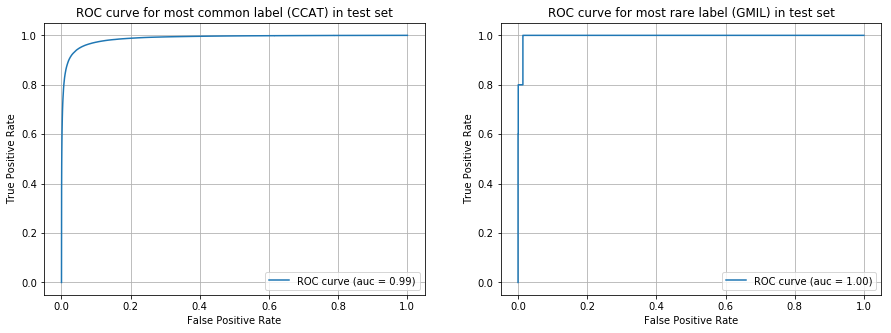

In [68]:
plot_roc_curve(testY, nblr_predictions_)

## NBSVM (Naive Bayes - Support Vector Machines)

In [7]:
def nblr_svm(x_train, y_train, x_test, y_test):
#     predictions = []
    predictions_labels = []
    def pr(y_i, y, x_train):
        p = x_train[y==y_i].sum(0)
        return (p+1) / ((y==y_i).sum()+1)
    def get_mdl(y, x_train):
        r = np.log(pr(1, y, x_train) / pr(0, y, x_train))
        m = LinearSVC()
        x_nb = x_train.multiply(r)
        return m.fit(x_nb, y), r
    for category in tqdm(range(y_train.shape[1])):
        x_train_str, _, y_train_str, _ = train_test_split(x_test, y_test, test_size=0.8,
                                                          random_state=42)
        y_str = vstack([y_train, y_train_str]).toarray()
        m, r = get_mdl(y_str[:, category].reshape([-1]), vstack([x_train, x_train_str]))
#         preds = m.predict_proba(testX.multiply(r))
        preds_labels = m.predict(testX.multiply(r))
        predictions_labels.append(preds_labels)
#         predictions.append(preds)
    return predictions_labels

In [8]:
nblr_svm_predictions_labels = nblr_svm(trainX, trainY, testX, testY)

HBox(children=(IntProgress(value=0, max=103), HTML(value='')))

In [9]:
nblr_svm_predictions_labels = np.stack(nblr_svm_predictions_labels, axis=1)

## One VS Rest Summary

In [11]:
def summary(name, y, pred, pred_prob=None):
    print(name + ":\n")
    print("Micro F1 score:", f1_score(y, pred, average='micro'))
    print("Macro F1 score:", f1_score(y, pred, average='macro'))
    if pred_prob is not None:
        print("Mean roc_auc_score:", roc_auc_score(y, pred_prob, average='macro'))
        print("Weighted mean roc_auc_score:", roc_auc_score(y, pred_prob,
                                                            average='weighted'))
    print("\n")

In [65]:
summary("Logistic Regression", testY.toarray(), lr_predictions_labels_, lr_predictions_)
summary("LinearSVC", testY.toarray(), svc_predictions_labels_)
summary("Naive Bayes", testY.toarray(), nb_predictions_labels_, nb_predictions_)
summary("LightGBM", testY.toarray(), lgbm_predictions_labels_, lgbm_predictions_)
summary("NBLR", testY.toarray(), nblr_predictions_labels_, nblr_predictions_)

Logistic Regression:

Micro F1 score: 0.5262513218618361
Macro F1 score: 0.07489664636863827
Mean roc_auc_score: 0.9804235195103767
Weighted mean roc_auc_score: 0.9759748131612761


LinearSVC:

Micro F1 score: 0.803763457942676
Macro F1 score: 0.4932146117598874


Naive Bayes:

Micro F1 score: 0.4921989965229007
Macro F1 score: 0.06645594776904942
Mean roc_auc_score: 0.6688458077088648
Weighted mean roc_auc_score: 0.860903666584659


LightGBM:

Micro F1 score: 0.7466097727707623
Macro F1 score: 0.46454112461446195
Mean roc_auc_score: 0.8965060068117068
Weighted mean roc_auc_score: 0.969998974246665


NBLR:

Micro F1 score: 0.8561432084384369
Macro F1 score: 0.7168344496868468
Mean roc_auc_score: 0.9912085951653353
Weighted mean roc_auc_score: 0.9894815639105985




In [12]:
summary("NBSVM", testY.toarray(), nblr_svm_predictions_labels)

NBSVM:

Micro F1 score: 0.8608097664758206
Macro F1 score: 0.7290163122941238




## Classifier Chains

#### LinearSVC

In [69]:
classifier = ClassifierChain(LinearSVC())
x_train_str, x_test_str, y_train_str, y_test_str = train_test_split(testX, testY, test_size=0.8,
                                                                    random_state=42)
y_str = vstack([trainY, y_train_str]).toarray()
classifier.fit(vstack([trainX, x_train_str]), y_str)
predictions = classifier.predict(x_test_str)

In [70]:
print("Classifier Chain + LinearSVC")
print("Micro F1 score:", f1_score(y_test_str.toarray(), predictions, average='micro'))
print("Macro F1 score:", f1_score(y_test_str.toarray(), predictions, average='macro'))

Classifier Chain + LinearSVC
Micro F1 score: 0.842758197812954
Macro F1 score: 0.6805685119739788


#### LGBM

In [71]:
classifier = ClassifierChain(lightgbm.LGBMClassifier())
x_train_str, x_test_str, y_train_str, y_test_str = train_test_split(testX, testY, test_size=0.8,
                                                                    random_state=42)
y_str = vstack([trainY, y_train_str]).toarray()
classifier.fit(vstack([trainX, x_train_str]), y_str)
lgbm_predictions = classifier.predict(x_test_str)

In [72]:
print("Classifier Chain + LGBM")
print("Micro F1 score:", f1_score(y_test_str.toarray(), lgbm_predictions, average='micro'))
print("Macro F1 score:", f1_score(y_test_str.toarray(), lgbm_predictions, average='macro'))

Classifier Chain + LGBM
Micro F1 score: 0.8023692472019098
Macro F1 score: 0.5046696646767941


# Dimensionality reduction using LSI

In [16]:
def build_lsa(x_train, x_test, dim=300):
    svd = TruncatedSVD(n_components=dim)
    x_lsi_train = svd.fit_transform(x_train)
    x_lsi_test = svd.transform(x_test)
    print('LSI output shape:', x_lsi_train.shape)
    explained_variance = svd.explained_variance_ratio_.sum()
    print("Sum of explained variance ratio: %d%%" % (int(explained_variance * 100)))
    return svd, x_lsi_train, x_lsi_test

svd, x_lsi_train, x_lsi_test = build_lsa(trainX, testX, dim=300)

LSI output shape: (23149, 300)
Sum of explained variance ratio: 28%


In [74]:
_, x_lsi_train_2d, x_lsi_test_2d = build_lsa(trainX, testX, dim=2)

LSI output shape: (23149, 2)
Sum of explained variance ratio: 1%


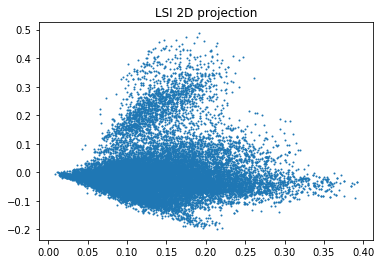

In [81]:
plt.scatter(x_lsi_train_2d[:,0], x_lsi_train_2d[:,1], s=1)
plt.title("LSI 2D projection")
plt.show()

# Multilabel classification + Dimensionality reduction

In [17]:
lgbm = lightgbm.LGBMClassifier(objective='binary', learning_rate=0.05)
lgbm_accuracies, lgbm_predictions, lgbm_predictions_labels = oneVSrest(x_lsi_train, trainY,
                                                                       x_lsi_test, testY, lgbm)

HBox(children=(IntProgress(value=0, max=103), HTML(value='')))

In [18]:
lgbm_predictions_ = [p[:, 1] for p in lgbm_predictions]
lgbm_predictions_ = np.stack(lgbm_predictions_, axis=1)
lgbm_predictions_labels_ = np.stack(lgbm_predictions_labels, axis=1)

In [19]:
summary("LightGBM", testY.toarray(), lgbm_predictions_labels_, lgbm_predictions_)

LightGBM:

Micro F1 score: 0.7676386567729572
Macro F1 score: 0.40550542067019296
Mean roc_auc_score: 0.892724968488726
Weighted mean roc_auc_score: 0.9742785942156472




# Results

<table>
  <caption>Results</caption>
  <tr>
    <td></td>
    <th scope="col">OVR+LR</th>
    <th scope="col">OVR+LinearSVC</th>
    <th scope="col">OVR+NaiveBayes</th>
    <th scope="col">OVR+LGBM</th>
    <th scope="col">NBSVM</th>
    <th scope="col">NBLR</th>
    <th scope="col">CC+LinearSVC</th>
    <th scope="col">CC+LGBM</th>
    <th scope="col">LSI+LGBM</th>
  </tr>
  <tr>
    <th scope="row">Micro F1 Score</th>
    <td>0.52</td>
    <td>0.80</td>
    <td>0.49</td>
    <td>0.74</td>
    <td>0.86</td>
    <td>0.85</td>
    <td>0.84</td>
    <td>0.80</td>
    <td>0.76</td>
  </tr>
  <tr>
    <th scope="row">Macro F1 Score</th>
    <td>0.07</td>
    <td>0.49</td>
    <td>0.06</td>
    <td>0.46</td>
    <td>0.72</td>
    <td>0.71</td>
    <td>0.68</td>
    <td>0.50</td>
    <td>0.40</td>
  </tr>
  <tr>
    <th scope="row">Mean ROC AUC</th>
    <td>0.98</td>
    <td>-</td>
    <td>0.66</td>
    <td>0.89</td>
    <td>-</td>
    <td>0.99</td>
    <td>-</td>
    <td>-</td>
    <td>0.89</td>
  </tr>
  <th scope="row">Weighted Mean ROC AUC</th>
    <td>0.97</td>
    <td>-</td>
    <td>0.86</td>
    <td>0.96</td>
    <td>-</td>
    <td>0.98</td>
    <td>-</td>
    <td>-</td>
    <td>0.97</td>
</table>
<br>
OVR - One VS Rest<br>
CC - Classifier Chains

Так как датасет несбалансированный и имеет небольшой процент положительных примеров, лучше использовать метрику F1. Наилучшие результаты показали NBSVM и NBLR, так же приемлемые результаты показал CC+LinearSVC. При этом для классификаторов с небольшим F1 и хорошим показателем ROC AUC можно подобрать порог для улучшения F1 метрики. Самые плохие результаты показал OVR+NaiveBayes.